## Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Читаем данные

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

# читаем данные и записываем в переменную
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Шаг 2. Предобработка данных

#### Предобработаем данные в таблице 'calls'

In [2]:
# получаем первые данные по таблице 'calls'
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


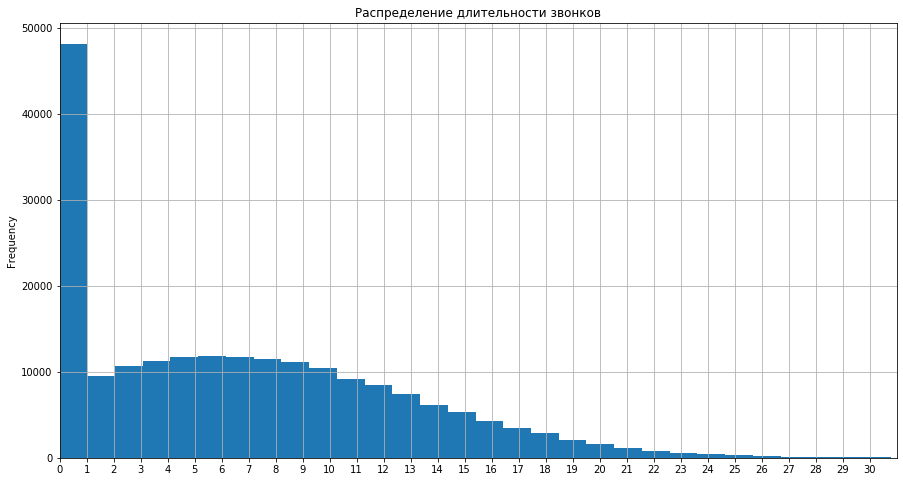

In [3]:
# оценим распределение длительности звонков
calls.duration.plot(kind='hist', figsize=(15,8), 
                    xticks=[i for i in range(31)], 
                    xlim=(0,31), grid=True, bins=37, 
                    title='Распределение длительности звонков')

Обнаружено большое количество звонков с продолжительностью 0.0 минут. Полагаю, что так система определяет звонки, которые адресат не принял. 

In [4]:
# избавимся от нулевых значений, так как денег за реализованный звонок Мегалайн не берет
calls = calls.query('duration > 0.0')

# округлим длительность в большую сторону, как делает оператор
calls['duration_ceil'] = calls.duration.apply(math.ceil)

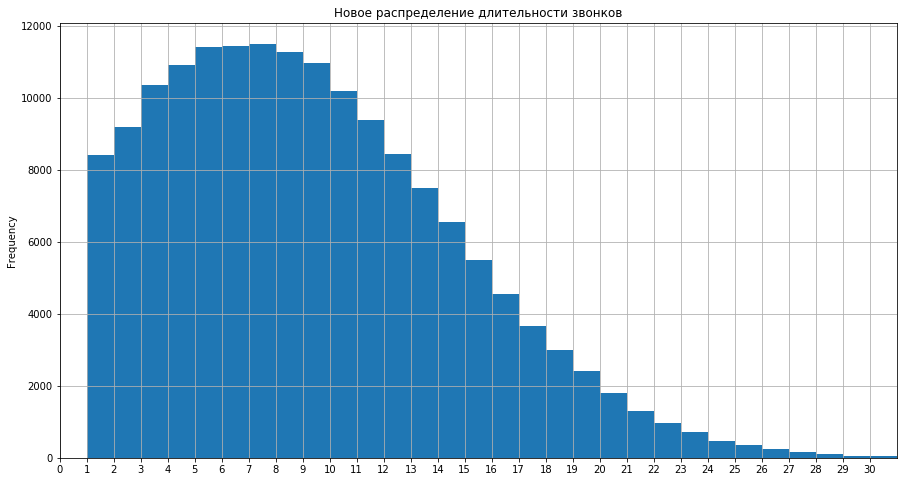

In [5]:
# оценим распределение длительности звонков
calls.duration_ceil.plot(kind='hist', figsize=(15,8), 
                    xticks=[i for i in range(31)], 
                    xlim=(0,31), grid=True, bins=37, 
                    title='Новое распределение длительности звонков')

Теперь очевидно, что длительность звонков имеет распределение Пуассона, что вполне логично

In [6]:
# изменим тип данных столбца с датой
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# добавим данные о месяце звонков для будущей группировки данных
calls['month'] = calls['call_date'].dt.month

In [7]:
# сгруппируем данные по user_id и месяцам
calls_stat = calls.pivot_table(index=['user_id', 'month'],  
                               values='duration_ceil', 
                               aggfunc='sum').reset_index()
calls_stat.columns = ['user_id', 'month', 'sum_of_calls_min']

In [8]:
calls_stat

,user_id,month,sum_of_calls_min
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3163,1498,10,247
3164,1499,9,70
3165,1499,10,449
3166,1499,11,612


In [9]:
# проверка на потерю данных
if calls['user_id'].unique().sum() == calls_stat['user_id'].unique().sum():
    print('Данные не потеряны')
else:
    print('Необходимо уточнение')

Данные не потеряны


#### Предобработаем данные в таблице 'internet'

In [10]:
# получаем первые данные по таблице 'internet'
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


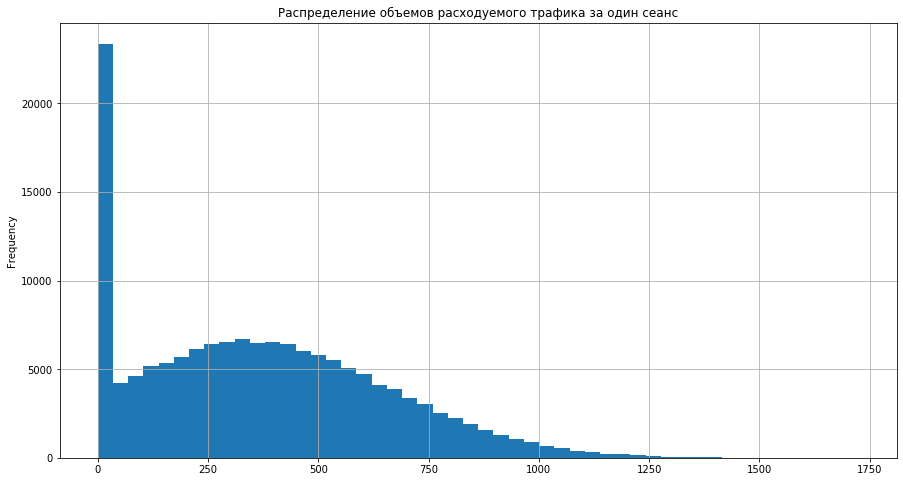

In [11]:
# оценим распределение потраченного трафика за одну сессию
internet.mb_used.plot(kind='hist', figsize=(15,8), 
                      grid=True, bins=50, 
                      title='Распределение объемов расходуемого трафика за один сеанс')

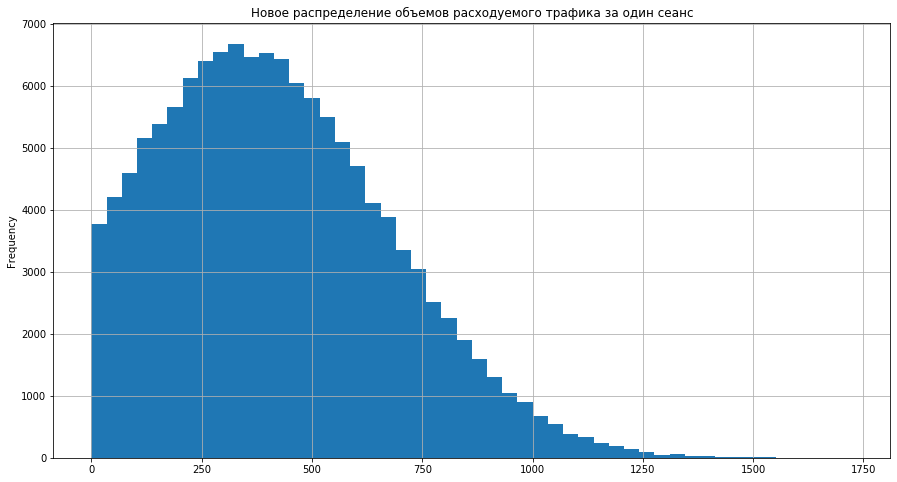

In [12]:
# избавимся от нулевых значений по аналогии со звонками
internet = internet.query('mb_used > 0.0')

# округлим длительность в большую сторону, как делает оператор
internet['mb_used_ceil'] = internet.mb_used.apply(math.ceil)

# оценим новое распределение потраченного трафика за одну сессию
internet.mb_used.plot(kind='hist', figsize=(15,8), 
                      grid=True, bins=50, 
                      title='Новое распределение объемов расходуемого трафика за один сеанс')

И распределение вновь похоже на пуассоновское

In [13]:
# изменим тип данных столбца с датой
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# добавим данные о месяце для будущей группировки данных
internet['month'] = internet['session_date'].dt.month

# сгруппируем данные по user_id, сделав разбивку по месяцам
internet_stat = internet.pivot_table(index=['user_id', 'month'],  
                               values='mb_used_ceil', 
                               aggfunc='sum').reset_index()

internet_stat.columns = ['user_id', 'month', 'sum_of_internet_mb']

In [14]:
# проверка на потерю данных
if internet['user_id'].unique().sum() == internet_stat['user_id'].unique().sum():
    print('Данные не потеряны')
else:
    print('Необходимо уточнение')

Данные не потеряны


#### Предобработаем данные в таблице 'messages'

In [15]:
# получаем первые данные по таблице 'messages'
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [16]:
# изменим тип данных столбца с датой
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# добавим данные о месяце для будущей группировки данных
messages['month'] = messages['message_date'].dt.month

# сгруппируем данные по user_id, сделав разбивку по месяцам
messages_stat = messages.pivot_table(index=['user_id', 'month'],  
                               values='message_date', 
                               aggfunc='count').reset_index()

# корректируем названия столбцов
messages_stat.columns = ['user_id', 'month', 'count_of_messages']
messages_stat

,user_id,month,count_of_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [17]:
# проверка на потерю данных
if messages['user_id'].unique().sum() == messages_stat['user_id'].unique().sum():
    print('Данные не потеряны')
else:
    print('Необходимо уточнение')

Данные не потеряны


#### Предобработаем данные в таблице 'users'

In [18]:
# получаем первые данные по таблице 'users'
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
# изменим тип данных столбца с датой
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


#### Добавим таблицу с выручкой каждого пользователя

In [20]:
# создаем отдельную таблицу с пользователями и их тарифами
user_revenue = users.loc[:,['user_id','tariff','city','churn_date','reg_date']]

# изменим дату подключения и прекращения пользования тарифом на месячный формат
user_revenue['churn_date'] = user_revenue['churn_date'].dt.month.fillna(15).astype(int)
user_revenue['reg_year'] = user_revenue['reg_date'].dt.year.astype(int)
user_revenue['reg_month'] = user_revenue['reg_date'].dt.month.astype(int)
user_revenue

,user_id,tariff,city,churn_date,reg_date,reg_year,reg_month
0,1000,ultra,Краснодар,15,2018-05-25,2018,5
1,1001,smart,Москва,15,2018-11-01,2018,11
2,1002,smart,Стерлитамак,15,2018-06-17,2018,6
3,1003,ultra,Москва,15,2018-08-17,2018,8
4,1004,ultra,Новокузнецк,15,2018-05-14,2018,5
...,...,...,...,...,...,...,...
495,1495,ultra,Иркутск,15,2018-08-28,2018,8
496,1496,smart,Вологда,15,2018-01-27,2018,1
497,1497,smart,Челябинск,15,2018-10-09,2018,10
498,1498,smart,Владикавказ,10,2018-07-19,2018,7


In [21]:
#джойним данные об использованных минутах, сообщениях и гигабайтов
minutes_included = user_revenue.merge(calls_stat, on='user_id', how='right')
messages_included = user_revenue.merge(messages_stat, on='user_id', how='right')
mb_per_month_included = user_revenue.merge(internet_stat, on='user_id', how='right')

#продублируем данные для будушего статистического анализа
minutes_for_stat = calls_stat
messages_for_stat = messages_stat
internet_for_stat = internet_stat

# выделим информацию о тарифах
user_tariff = users.loc[:,['user_id', 'tariff']]

# добавим информацию о тарифах в таблицы для статистического анализа
minutes_for_stat = minutes_for_stat.merge(user_tariff, on='user_id', how='left')
messages_for_stat = messages_for_stat.merge(user_tariff, on='user_id', how='left')
internet_for_stat = internet_for_stat.merge(user_tariff, on='user_id', how='left')

messages_for_stat

,user_id,month,count_of_messages,tariff
0,1000,5,22,ultra
1,1000,6,60,ultra
2,1000,7,75,ultra
3,1000,8,81,ultra
4,1000,9,57,ultra
...,...,...,...,...
2712,1498,10,42,smart
2713,1499,9,11,smart
2714,1499,10,48,smart
2715,1499,11,59,smart


In [22]:
# определим функцию, рассчитывающую выручку от использования минут сверх пакета
def calls_minutes(row):
    if row['tariff'] == 'smart':
        if 500 - row['sum_of_calls_min'] < 0:
            return (row['sum_of_calls_min'] - 500) * 3
        else:
            return 0
    else:
        if 3000 - row['sum_of_calls_min'] < 0:
            return (row['sum_of_calls_min'] - 3000) * 1
        else:
            return 0

# аналогично с сообщениями
def messages_count(row):
    if row['tariff'] == 'smart':
        if 50 - row['count_of_messages'] < 0:
            return (row['count_of_messages'] - 50) * 3
        else:
            return 0
    else:
        if 1000 - row['count_of_messages'] < 0:
            return (row['count_of_messages'] - 1000) * 1
        else:
            return 0   
        
# аналогично с интернетом
def internet_mb(row):
    if row['tariff'] == 'smart':
        if 15360 - row['sum_of_internet_mb'] < 0:
            return (row['sum_of_internet_mb'] - 15360) * 0.2
        else:
            return 0
    else:
        if 30720 - row['sum_of_internet_mb'] < 0:
            return (row['sum_of_internet_mb'] - 30720) * 0.15
        else:
            return 0           

# применим определенные функции к датасету
minutes_included['revenue'] = minutes_included.apply(calls_minutes, axis=1)
messages_included['revenue'] = messages_included.apply(messages_count, axis=1)
mb_per_month_included['revenue'] = mb_per_month_included.apply(internet_mb, axis=1)

In [23]:
# выделим необходимые данные в отдельный датафрейм
minutes_revenue = minutes_included.loc[:,['user_id', 'city', 'tariff', 'month', 'revenue']]
messages_revenue = messages_included.loc[:,['user_id', 'city', 'tariff', 'month', 'revenue']]
internet_revenue = mb_per_month_included.loc[:,['user_id', 'city', 'tariff', 'month', 'revenue']]

# объединим информацию о выручке в единый датафрейм
total_revenue = pd.concat([minutes_revenue, messages_revenue, internet_revenue])

# сгруппируем по комбинации значений ['user_id', 'city', 'tariff', 'month'], 
# чтобы получить дополнительную выручку сверх базового тарифа
user_revenue_grouped = total_revenue.pivot_table(index=['user_id', 'city', 'tariff', 'month'],  
                               values='revenue', 
                               aggfunc='sum').reset_index()

# определим функцию, добавляющую базовую стоимость тарифа к каждому наблюдению
def tariff_cost(row):
    if row['tariff'] == 'ultra':
        return row['revenue'] + 1950
    else: 
        return row['revenue'] + 550
    
# применим функцию к датафрейму
user_revenue_grouped['revenue'] = user_revenue_grouped.apply(tariff_cost, axis=1)

### Шаг 3. Статистический анализ данных

Статистика использования минут пользователей тарифов Ультра и Смарт

Тариф 'Ультра'

1) Среднее количество проговоренных минут равно 548 в месяц
2) Дисперсия проговоренных минут равна 93240 в месяц
3) Среднеквадратическое отклонение проговоренных минут равно 306 в месяц
4) Коэффициент вариации проговоренных минут равен 0.56 в месяц

Тариф 'Смарт'

1) Среднее количество проговоренных минут равно 420 в месяц
2) Дисперсия проговоренных минут равна 35703 в месяц
3) Среднеквадратическое отклонение проговоренных минут равно 189 в месяц
4) Коэффициент вариации проговоренных минут равен 0.34 в месяц


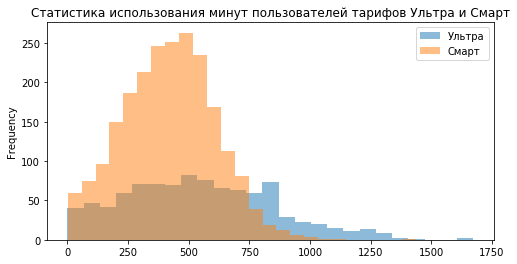



Статистика использования сообщений пользователей тарифов Ультра и Смарт

Тариф 'Ультра'

1) Среднее количество отправленных сообщений равно 62 в месяц
2) Дисперсия отправленных сообщений равна 2108 в месяц
3) Среднеквадратическое отклонение отправленных сообщений равно 46 в месяц
4) Коэффициент вариации отправленных сообщений равен 0.75 в месяц

Тариф 'Смарт'

1) Среднее количество отправленных сообщений равно 39 в месяц
2) Дисперсия отправленных сообщений равна 718 в месяц
3) Среднеквадратическое отклонение отправленных сообщений равно 27 в месяц
4) Коэффициент вариации отправленных сообщений равен 0.44 в месяц


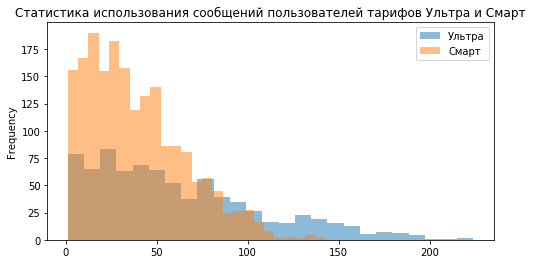



Статистика использования интернета пользователей тарифов Ультра и Смарт

Тариф 'Ультра'

1) Среднее количество потраченных мегабайт равно 19707 в месяц
2) Дисперсия потраченных мегабайт равна 98645117 в месяц
3) Среднеквадратическое отклонение потраченных мегабайт равно 9933 в месяц
4) Коэффициент вариации потраченных мегабайт равен 0.5 в месяц

Тариф 'Смарт'

1) Среднее количество потраченных мегабайт равно 16244 в месяц
2) Дисперсия потраченных мегабайт равна 34324672 в месяц
3) Среднеквадратическое отклонение потраченных мегабайт равно 5859 в месяц
4) Коэффициент вариации потраченных мегабайт равен 0.3 в месяц


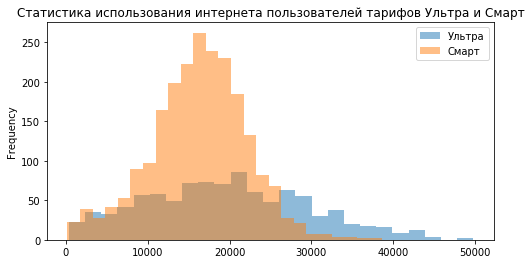

In [24]:
# автоматизируем статистический анализ исследуемых переменных
stats = {'minutes':['Статистика использования минут пользователей тарифов Ультра и Смарт', 
                    'проговоренных минут', minutes_for_stat, 'sum_of_calls_min'], 
         'messages':['Статистика использования сообщений пользователей тарифов Ультра и Смарт', 'отправленных сообщений', messages_for_stat, 'count_of_messages'], 
         'internet':['Статистика использования интернета пользователей тарифов Ультра и Смарт', 'потраченных мегабайт', internet_for_stat, 'sum_of_internet_mb']}
for stat in stats.keys():
    print(stats[stat][0])
    print()
    print("Тариф 'Ультра'")
    print()
    print('1) Среднее количество', stats[stat][1], 'равно', 
          math.ceil(stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]].mean()), 'в месяц')
    print('2) Дисперсия', stats[stat][1], 'равна', 
          math.ceil(np.var(stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]])), 'в месяц')
    print('3) Среднеквадратическое отклонение', stats[stat][1], 'равно', 
          math.ceil(np.std(stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]])), 'в месяц')
    print('4) Коэффициент вариации', stats[stat][1], 'равен', 
          round(np.std(stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]]) / stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]].mean(), 2), 'в месяц')
    print()
    print("Тариф 'Смарт'")
    print()
    print('1) Среднее количество', stats[stat][1], 'равно', 
          math.ceil(stats[stat][2][stats[stat][2]['tariff'] == 'smart'][stats[stat][3]].mean()), 'в месяц')
    print('2) Дисперсия', stats[stat][1], 'равна', 
          math.ceil(np.var(stats[stat][2][stats[stat][2]['tariff'] == 'smart'][stats[stat][3]])), 'в месяц')
    print('3) Среднеквадратическое отклонение', stats[stat][1], 'равно', 
          math.ceil(np.std(stats[stat][2][stats[stat][2]['tariff'] == 'smart'][stats[stat][3]])), 'в месяц')
    print('4) Коэффициент вариации', stats[stat][1], 'равен', 
          round(np.std(stats[stat][2][stats[stat][2]['tariff'] == 'smart'][stats[stat][3]]) / stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]].mean(), 2), 'в месяц')
   
    stats[stat][2][stats[stat][2]['tariff'] == 'ultra'][stats[stat][3]].plot(kind='hist', title=stats[stat][0], figsize=(8,4), bins=25, alpha=0.5)
    stats[stat][2][stats[stat][2]['tariff'] == 'smart'][stats[stat][3]].plot(kind='hist', title=stats[stat][0], figsize=(8,4), bins=25, alpha=0.5)
    plt.legend(('Ультра', 'Смарт'))
    plt.show()
    print()
    print()

#### По результатам расчетов статистических показателей в разрезе тарифов получены следующие выводы:
- Распределения использованных минут и интернета больше похоже на нормальное, а сообщений - на пуассоновское;
- Клиенты тарифа «Ультра» в среднем потребляют больше минут, сообщений и трафика, чем пользователи тарифа «Смарт», но при этом их коэффициент вариации по данным характеристикам значительно выше (что также видно по графикам, характеристики распределены в гораздо большем диапазоне);
- Если судить по средним значениям, пользователи тарифа «Смарт» гораздно эффективнее используют свой тариф, так как большинство значений исследуемвых характеристик лежит в районе верхней границы лимитов тарифа. В случае тарифа «Ультра» мы видим, что мало кто из пользователей использует тариф по-максимуму. Видимо такой тариф подключают те, кому его стоимость не так важна, либо важен только один увеличенный лимит (звонки, смс, интернет), что объясняет такую высокую вариацию факторов.
- Вариация использования интернета, вне зависимости от выбранного тарифа, обладает значительно меньшей вариацией, нежели звонки и СМС. Скорее всего, интернет используется в том числе как замена вышесказанным функциям, поэтому его использование более равномерное. 

Данные выводы подтверждают мое субъективное мнение, что большинству пользователей в современном мире от сотовых операторов нужен именно интернет, так как он заменяет и телефонные звонки, и классические СМС-сообщения, и обладает широким спектром возможностей использования. Именно этот фактор обеспечивает меньшую вариативность распределения использования интернет-трафика по сравнению со звонками и СМС.

### Шаг 4. Проверка гипотез

#### Прежде чем проверять гипотезы, их необходимо сформировать:
1) Первая нулевая гипотеза звучит так: средние выручки пользователей тарифов «Ультра» и «Смарт» равны; 

2) Гипотеза, альтернативная первой нулевой, будет звучать так: средние выручки пользователей тарифов «Ультра» и «Смарт» не равны;

3) Вторая гипотеза звучит так: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;

4) Гипотеза, альтернативная второй нулевой, будет звучать так: средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов.

Нулевые гипотизы были сформированы так, чтобы использовать в них знак равенства. Для проверки гипотез будет использован метод сравнения средних значений двух генеральных совокупностей.


In [25]:
# исследуем выборки пользователей разных тарифов
ultra = user_revenue_grouped[user_revenue_grouped['tariff'] == 'ultra']['revenue']
smart = user_revenue_grouped[user_revenue_grouped['tariff'] == 'smart']['revenue']
results = st.ttest_ind(ultra, smart)

alpha = .01

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
    print('Если средняя выручка не равна, необходимо выяснить, какой тариф приносит в среднем больше денег')
    if smart.mean() < ultra.mean():
        print("Тариф 'Ультра' в среднем приносит больше денег")
    else:
        print("Тариф 'Смарт' в среднем приносит больше денег")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.9340374529548145e-180
Отвергаем нулевую гипотезу
Если средняя выручка не равна, необходимо выяснить, какой тариф приносит в среднем больше денег
Тариф 'Ультра' в среднем приносит больше денег


In [26]:
# исследуем выборки пользователей из Москвы и других регионов
moscow = user_revenue_grouped[user_revenue_grouped['city'] == 'Москва']['revenue']
other = user_revenue_grouped[user_revenue_grouped['city'] != 'Москва']['revenue']
results = st.ttest_ind(moscow, other, equal_var = False)

alpha = .01

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.48665533627642577
Не получилось отвергнуть нулевую гипотезу


#### По результатам проверки статистических гипотез получены следующие выводы:
- Гипотеза о равенстве выручек пользователей тарифов «Ультра» и «Смарт» была отвергнута, при этом существует 1% вероятность ошибки первого рода, когда выручка данных тарифов в действительности может быть равна. Из этого действует вывод, что скорее всего выручки пользователей разных тарифов отличаются, дополнительный анализ средней выручки по тарифам показывает преимущество в выручке тарифа «Ультра»;
- Гипотеза о равенстве выручек пользователей из Москвы и других регионов не была отвергнута, при этом существует достаточно высокая вероятность получить данный результат при верной нулевой гипотизе о равенстве выручек пользователей из Москвы и прочих регионов. Вывод - скорее всего выручка не зависит от того, находится клиент в Москве или нет.

### Шаг 5. Общий вывод

#### По результатам исследования можно сделать следующие выводы:
- Пользователи тарифа «Ультра» в среднем потребляют больше минут, СМС и гигабайт, чем пользователи тарифа «Смарт», однако делают это с гораздо большей вариацией;
- Выручка пользователей различных тарифов, скорее всего, отличается в пользу тарифа «Ультра». На самом деле, этот вывод интуитивно понятен, учитывая более чем в 3 раза различающуюся базовую стоимость рассматриваемых тарифов. Если использующий тариф «Смарт» пользователь значительно выбивается из лимитов, он непременно перейдет на «Ультра» в целях экономии денежных средств;
- Выручка, скорее всего, не зависит от нахождения пользователя в Москве. Большинство пользователей не выходят за пределы бесплатных лимитов тарифов, и, учитывая факт унификации стоимости тарифов для всех регионов, включая Москву, данный вывод так же интуитивно понятен;
- СМС-сообщения в традиционном виде начинают вымирать - коэффициент вариации слишком велик, что свидетельствует об усложнении точного прогнозирования использования данного вида коммуникационных услуг. Если поддержка инфраструктуры СМС-сообщений требует больших финансовых вложений, от неё стоит вообще отказаться, так как в будущем из-за развития мессенджеров ситуация будет только усугубляться;
- Минуты разговоров, хоть и обладают большой вариацией, остаются одним из важнейших видов коммуникационных услуг на данное время. Однако, когда интернет будет распространен повсеместно, и все больше людей привыкнет звонить друг-другу с помощью мессенджеров, ситуация может значительно усложниться;
- Относительно низкая вариация использованного трафика говорит о ключевой роли интернета в услугах мобильных операторов. Интернет постепенно поглощает функцию более традиционных телефонных разговоров и СМС-сообщений, и при этом обладает большим количеством прочих функций. Существует предположение, что в будущем это будет единственная услуга мобильных операторов.

Был сделан вывод, что тариф «Ультра» в среднем приносит больше выручки, и поэтому целесообразно направить маркетинговые мероприятия именно на этот тариф, в том числе предлагая пользователям «Смарт» «прокачать» свой тариф.